In [1]:
# Import packages
%load_ext autoreload
%autoreload 

import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit
import seaborn as sns
from time import time as tm
from NeuroRNN import RateModel
from utils import GetBlockErdosRenyi, ToNP


# Choose a device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device =',device)



Device = mps


In [2]:
### These are all of the parameters that you might want to change.

# Number of neurons in recurrent net
N = 2000

# Number of sims to run in parallel
batch_size = 1

# Duration of simulation in ms
T = 1000
dt = 0.25


# Number of excitatory, inhibitory, and external neurons
Ne = int(N*.8)
Ni = N-Ne
Nx = int(N*.2)

# Connection weights
jee = 0.48
jei = -2.9
jie = 2.2
jii = -4.8
jex = 3.5
jix = 2.6

# Connection probabilities
p=0.1

# Rate of external population
rx0=10.0

# Time constants
taue = 20
taui = 10


In [3]:
### These are all of the parameters generated for sims

with torch.no_grad():
    
    # Connection strengths and probabilities
    J0 = np.array([[jee, jei], [jie, jii]])/np.sqrt(N)
    Jx0 = np.array([[jex], [jix]])/np.sqrt(N)
    P = np.array([[p, p], [p, p]])
    Px = np.array([[p], [p]])
    
    
    # Discretized time
    time = np.arange(0,T,dt)
    Nt = len(time)

    # Get connectivity matrices
    t0=tm()
    J = GetBlockErdosRenyi((Ne,Ni),J0,P).to(device)
    Jx = GetBlockErdosRenyi((Nx,),Jx0,Px,(Ne,Ni)).to(device)
    tJ = tm()-t0
    print('Time to generate connectivity:',tJ,'s')

    # Array of synaptic timescales
    tau = torch.zeros(N).to(device)
    tau[:Ne] = taue
    tau[Ne:] = taui
    eta = dt/tau
    
    # External rates
    rx = rx0 + torch.zeros(batch_size,Nx).to(device)
    
    # Create model
    model = RateModel(J, Jx, f='relu', eta = eta).to(device)
    
    

Time to generate connectivity: 0.08608412742614746 s


In [4]:

with torch.no_grad():
    
    # Run simulation
    t0=tm()
    r = model(rx, Nt)
    tRateSim = tm()-t0
    print('Time for rate sim:',tRateSim,'s')

    # Get e and i rates
    re = ToNP(r[0,:,:Ne])
    ri = ToNP(r[0,:,Ne:])   
    
    # Get mean rates at last time point (approx fixed point)
    mre = re[-1,:].mean()
    mri = ri[-1,:].mean()

    print('Mean E and I rates from simulation:',mre,mri,'Hz')
    
    # Compute R, X, and Z (which we previously called T)
    # Since X is not time-dependent, we need to tile it across time
    R = ToNP(model.recurrent_layer(r[0,:,:]))
    X = ToNP(model.input_layer(rx[0,:]))
    X = np.tile(X,[Nt,1])
    Z = X+R


[]


Time for rate sim: 0.7661020755767822 s
Mean E and I rates from simulation: 6.8874645 14.646684 Hz


[]

[]

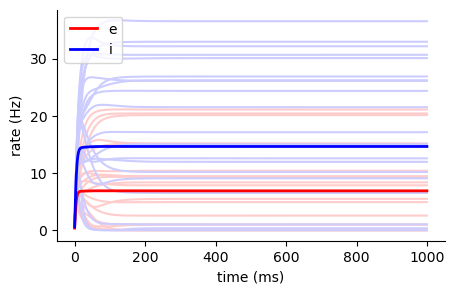

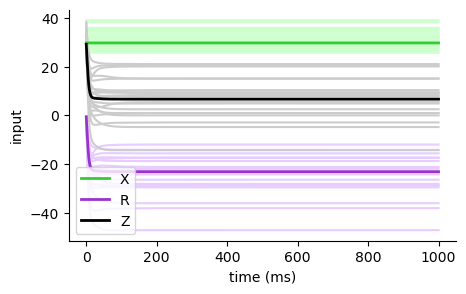

In [5]:
### This code cell plots some results of the sim    

numplot=20

plt.figure(figsize=(5,3))
plt.plot(time,re[:,:numplot],color=[1,.8,.8])
plt.plot(time,ri[:,-numplot:],color=[.8,.8,1])
plt.plot(time,re.mean(axis=1),'r',lw=2,label='e')
plt.plot(time,ri.mean(axis=1),'b',lw=2,label='i')    
plt.xlabel('time (ms)')
plt.ylabel('rate (Hz)')
sns.despine()
plt.legend()

plt.figure(figsize=(5,3))
plt.plot(time,X[:,:numplot],color=[.8,1,.8])
plt.plot(time,R[:,:numplot],color=[.9,.8,1])
plt.plot(time,Z[:,:numplot],color=[.8,.8,.8])
plt.plot(time,X.mean(axis=1),color=[.2,.8,.2],lw=2,label='X')
plt.plot(time,R.mean(axis=1),color=[.6,.2,.8],lw=2,label='R')
plt.plot(time,Z.mean(axis=1),color=[0,0,0],lw=2,label='Z')
plt.xlabel('time (ms)')
plt.ylabel('input')  
sns.despine()
plt.legend()

[]